<a href="https://colab.research.google.com/github/OnurKerimoglu/bayesian_mmm/blob/main/bayesian_mmm_example_robert_kuebler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From: https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a

By Robert Kübler

# Install / Import Packages

In [3]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=df493f8351dbd191c672c56c4e0cca1cf502ed763e329198b4540af18f278af5
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [4]:
import pandas as pd
import numpy as np
import pymc3 as pm3
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

# Prepare Data

In [5]:
data = pd.read_csv(
  'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
  parse_dates=['Date'],
  index_col='Date'
)

X = data.drop(columns=['Sales'])
y = data['Sales']

# Define Model

## Carryover and saturation functions

In [6]:
import theano.tensor as tt

def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

## The MMM Model

In [10]:
import pymc3 as pm3

with pm3.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm3.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm3.Exponential(f'sat_{channel}', lam=1)
        car = pm3.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm3.Exponential('base', lam=0.0001)
    noise = pm3.Exponential('noise', lam=0.0001)
    
    sales = pm3.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )

## Fit the model

In [12]:
import arviz as az
with mmm:
  trace = pm3.sample(return_inferencedata=True, tune=3000)
  #trace_summary = az.summary(trace)

ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


NameError: ignored

# Analyze the results


## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2705de87c0>,
      dtype=object)

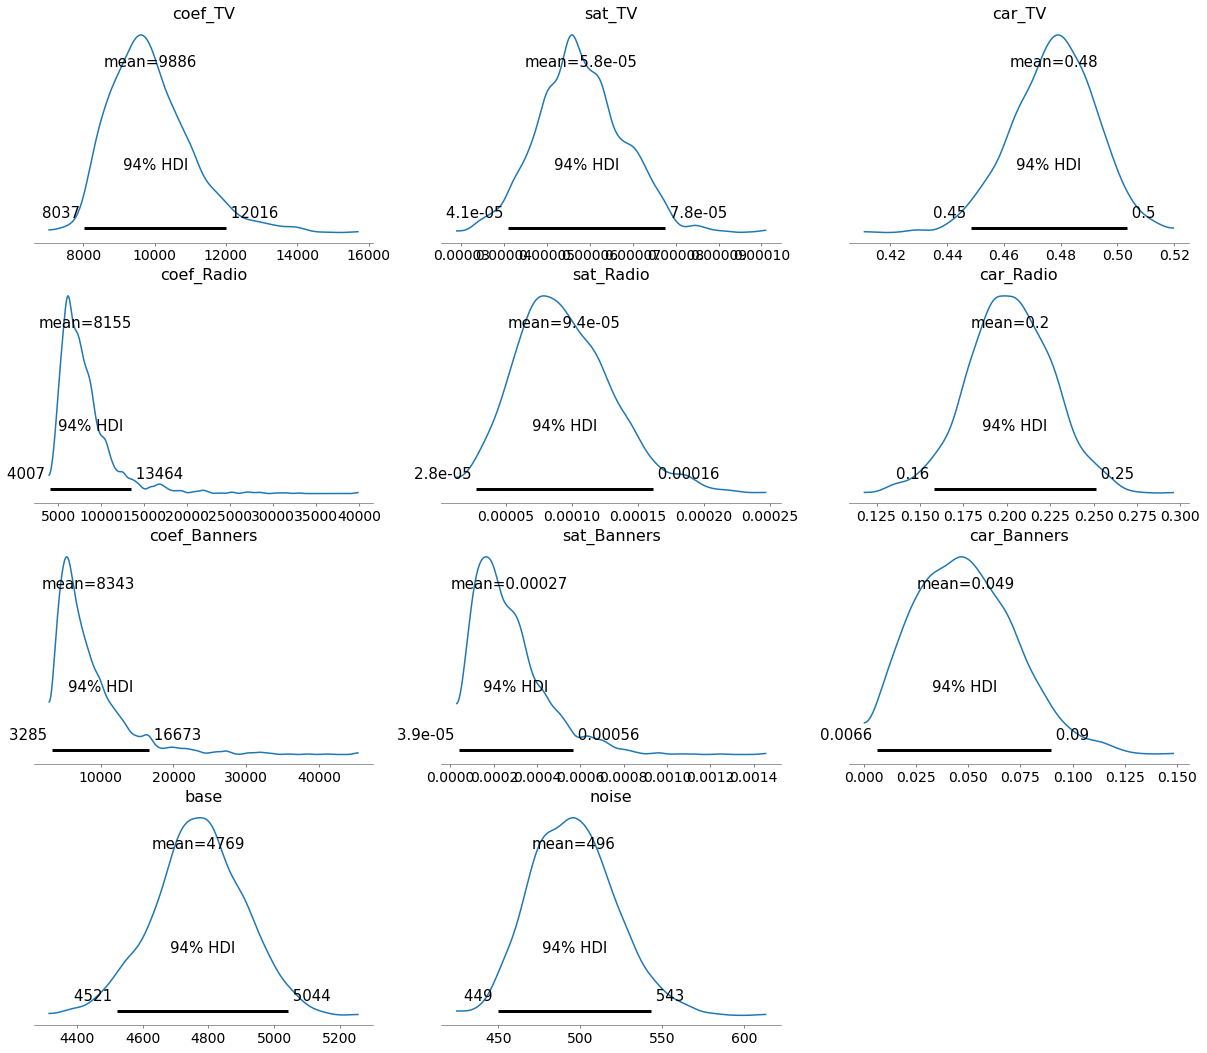

In [13]:
import arviz as az

az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

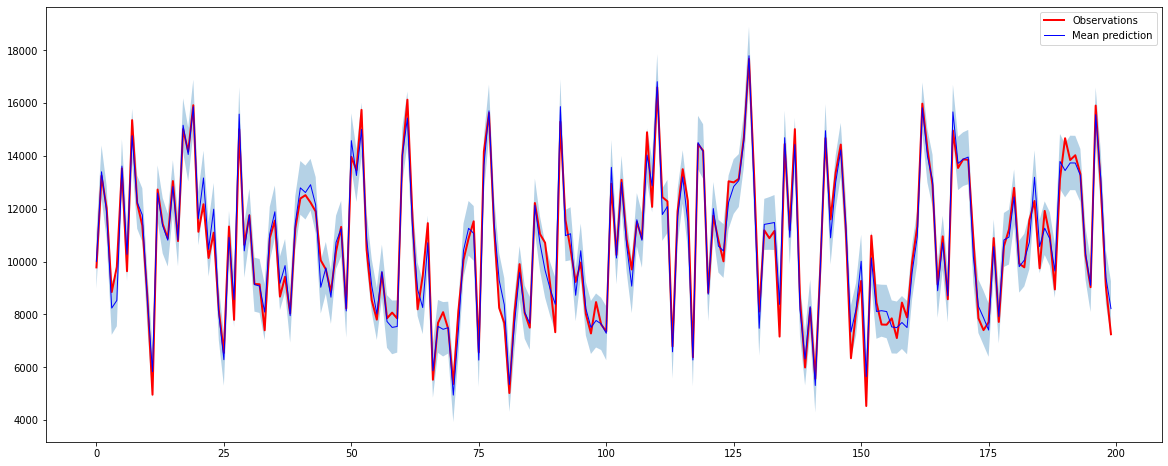

In [18]:
import matplotlib.pyplot as plt
import numpy as np

with mmm:
    posterior = pm3.sample_posterior_predictive(trace)

means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

## Channel Contributions

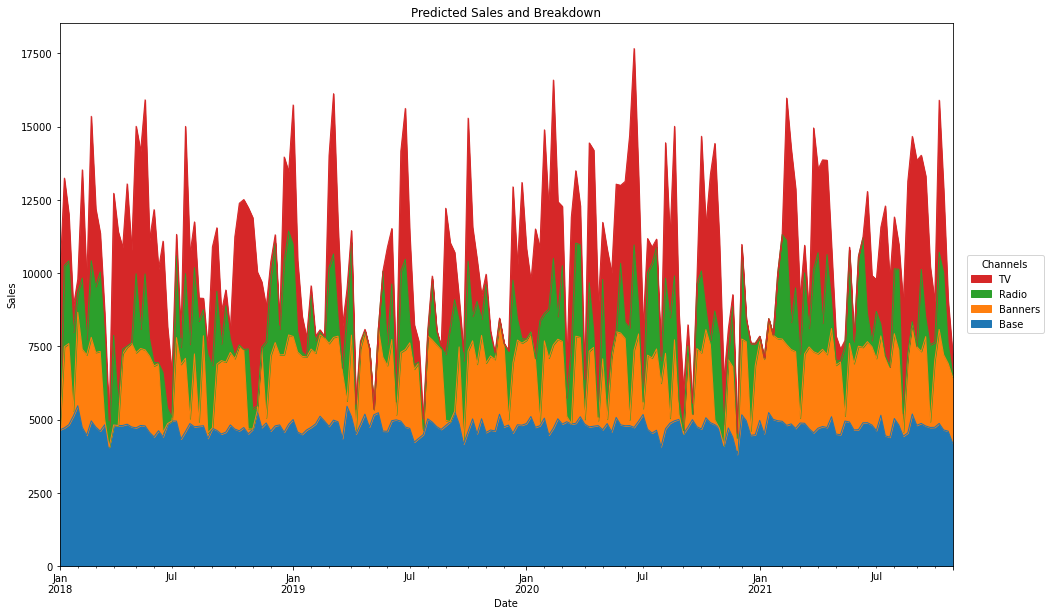

In [21]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            #.reshape(4000, 200)
            .reshape(2000, 200)
            .mean(0)
           )

channels = ['Banners', 'Radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)